## Assignment 1- Ladan Tazik

Comparing run time complexity for large enough data (at least one million string) of different implementations using 

- linear search,
- binary search,
- hashing, 
- Bloom filter,
- Cuckoo filter

In [21]:
import random
import string
import time
import matplotlib.pyplot as plt
import numpy as np
import unittest
import mmh3

## Step 1: Generate a synthetic dataset and save in local directory

In [22]:
#  synthetic dataset of usernames of length 10
def generate_usernames(n, length=10):
    return [''.join(random.choices(string.ascii_lowercase, k=length)) for _ in range(n)]

# Create dataset of 1M
n = 1_000_000  
usernames = generate_usernames(n)

with open("synthetic_usernames_5.txt", "w") as file:
    for username in usernames:
        file.write(username + "\n")


## Step 2: Implementation of the search methods

In [39]:
# Function for linear search
def linear_search(username, data_list):
    """ get a list and check if username exists in the list"""
    return username in data_list

# Function for binary search
def binary_search(username, data_sortedList):
    """Binary search implementation using a sorted list."""
    left, right = 0, len(data_sortedList) - 1
    while left <= right:
        mid = (left + right) // 2
        if data_sortedList[mid] == username:
            return True
        elif data_sortedList[mid] < username:
            left = mid + 1
        else:
            right = mid - 1
    return False

#Hashing
class HashTable:
    """
    HashTable implementation using Python's built-in set.
    """
    def __init__(self):
        self.table = set()
    
    def insert(self, key: str):
        """Inserts a key into the hash table."""
        self.table.add(key)
    
    def lookup(self, key: str) -> bool:
        """Checks if a key exists in the hash table."""
        return key in self.table
    
    def delete(self, key: str):
        """Removes a key from the hash table if it exists."""
        self.table.discard(key)



class BloomFilter:
    """
    Implementation of a Bloom Filter using mmh3 for hash functions.
    A Bloom Filter is a probabilistic data structure that provides fast membership testing
    with a possibility of false positives but no false negatives.
    """
    
    def __init__(self, size: int, hash_count: int):
        """
        Initializes the Bloom Filter.
        
        :param size: The number of bits in the bit array.
        :param hash_count: The number of hash functions to use.
        """
        self.size = size  # The number of bits in the bit array.
        self.hash_count = hash_count  # The number of hash functions used.
        self.bit_array = np.zeros(size, dtype=bool)  # Using NumPy for efficiency.
    
    def _hashes(self, key: str):
        """
        Generates multiple hash values for a given key using mmh3.
        
        :param key: The string key to hash.
        :return: A list of hash values.
        """
        return [mmh3.hash(key, i) % self.size for i in range(self.hash_count)]
    
    def insert(self, key: str):
        """
        Inserts a key into the Bloom Filter by setting bits at multiple hash positions.
        
        :param key: The string key to insert.
        """
        for hash_value in self._hashes(key):
            self.bit_array[hash_value] = True
    
    def lookup(self, key: str) -> bool:
        """
        Checks if a key might exist in the Bloom Filter.
        
        :param key: The string key to check.
        :return: True if the key might exist (possible false positive), False if the key does not exist.
        """
        return all(self.bit_array[hash_value] for hash_value in self._hashes(key))
    
    #Delete not supported
    
    
class CuckooFilter:
    def __init__(self, capacity, bucket_size, fingerprint_size):
        self.capacity = capacity  # Number of buckets
        self.bucket_size = bucket_size  # Entries per bucket
        self.fingerprint_size = fingerprint_size  # Fingerprint size in bits
        self.buckets = [np.array([], dtype=np.uint32) for _ in range(capacity)]  # Optimized with NumPy

    def _hash(self, value):
        """Computes primary hash index for storing value."""
        return mmh3.hash(value) % self.capacity

    def _get_fingerprint(self, value):
        """Generates a small fingerprint for the value."""
        random.seed(mmh3.hash(value))  # Seed based on hash of value
        return random.getrandbits(self.fingerprint_size) & ((1 << self.fingerprint_size) - 1)  # Ensures valid range

    def insert(self, value):
        """Inserts a value into the Cuckoo Filter."""
        fingerprint = self._get_fingerprint(value)
        index1 = self._hash(value)
        index2 = (index1 ^ mmh3.hash(str(fingerprint), seed=42)) % self.capacity  # FIXED

        bucket1 = self.buckets[index1]
        bucket2 = self.buckets[index2]

        # If fingerprint already exists, return True
        if fingerprint in bucket1 or fingerprint in bucket2:
            return True  

        # Try inserting into the available bucket
        if bucket1.size < self.bucket_size:
            self.buckets[index1] = np.append(bucket1, fingerprint)
            return True
        if bucket2.size < self.bucket_size:
            self.buckets[index2] = np.append(bucket2, fingerprint)
            return True

        # Eviction strategy with max relocation attempts
        max_relocations = 50
        for _ in range(max_relocations):
            if random.random() < 0.5:
                evicted_fingerprint = random.choice(bucket1.tolist())
                self.buckets[index1] = np.delete(bucket1, np.where(bucket1 == evicted_fingerprint))
                self.buckets[index1] = np.append(self.buckets[index1], fingerprint)
            else:
                evicted_fingerprint = random.choice(bucket2.tolist())
                self.buckets[index2] = np.delete(bucket2, np.where(bucket2 == evicted_fingerprint))
                self.buckets[index2] = np.append(self.buckets[index2], fingerprint)

            fingerprint = evicted_fingerprint
            index1 = (index1 ^ mmh3.hash(str(fingerprint), seed=42)) % self.capacity

            if self.buckets[index1].size < self.bucket_size:
                self.buckets[index1] = np.append(self.buckets[index1], fingerprint)
                return True

        return False  # Insertion failed after max attempts

    def lookup(self, value):
        """Checks if a value exists in the Cuckoo Filter."""
        fingerprint = self._get_fingerprint(value)
        index1 = self._hash(value)
        index2 = (index1 ^ mmh3.hash(str(fingerprint), seed=42)) % self.capacity  # FIXED
        return fingerprint in self.buckets[index1] or fingerprint in self.buckets[index2]

    def delete(self, value):
        """Removes a value from the Cuckoo Filter."""
        fingerprint = self._get_fingerprint(value)
        index1 = self._hash(value)
        index2 = (index1 ^ mmh3.hash(str(fingerprint), seed=42)) % self.capacity  # FIXED
        bucket1 = self.buckets[index1]
        bucket2 = self.buckets[index2]

        if fingerprint in bucket1:
            self.buckets[index1] = np.delete(bucket1, np.where(bucket1 == fingerprint))
            return True
        if fingerprint in bucket2:
            self.buckets[index2] = np.delete(bucket2, np.where(bucket2 == fingerprint))
            return True

        return False  # Not found



## Step 3: Initializing the data structures appropriate for each method

In [ ]:
# Store logins in different structures
login_list = usernames.copy()  # List for linear search
sorted_login_list = sorted(usernames)  # Sorted array for binary search
login_hash_table = set(usernames)  # Hash table for fast lookup

#bloom obj
b_filter = BloomFilter(size=1000, hash_count=3)
for username in usernames:
    b_filter.insert(username)


#cuckoo
c_filter = CuckooFilter(capacity=100000, bucket_size=4, fingerprint_size=16)
from concurrent.futures import ThreadPoolExecutor

def insert_into_cuckoo(username):
    c_filter.insert(username)

with ThreadPoolExecutor(max_workers=8) as executor: # make it more effient when inserting using all threads
    executor.map(insert_into_cuckoo, usernames)

In [58]:
b_look_up_time = measure_runtime(b_filter,usernames) # test for all usernames
b_look_up_time

3.7365236282348635e-06

In [62]:
c_look_up_time = measure_runtime(c_filter,usernames)  # test for all usernames, avoided doing so for lin and binary search
c_look_up_time

2.4165255308151244e-05

In [60]:
def measure_lookup_runtime(search_function, data_structure, test_sample):
    """
    Measures the lookup runtime for a given search function or a data structure with a `lookup` method.
    
    Parameters:
    - search_function (function or object): A function to perform lookup or an object with a `lookup` method.
    - data_structure (object): The data structure used for lookup.
    - test_sample (list): Sample dataset to measure lookup runtime.
    
    Returns:
    - float: The average lookup time.
    """
    lookup_times = []

    for username in test_sample:
        start = time.time()

        # Check if search_function is an object with a `lookup` method
        if hasattr(search_function, 'lookup') and callable(getattr(search_function, 'lookup')):
            search_function.lookup(username)  # Call the `lookup` method of the object
        else:
            search_function(username, data_structure)  # Call the function directly

        lookup_times.append(time.time() - start)

    return np.mean(lookup_times) if lookup_times else 0  # Avoid division by zero


In [57]:
test_sample = random.sample(usernames,1000)
# Measure lookup performance across all methods
results = {
    "Linear Search": measure_lookup_runtime(linear_search, login_list, test_sample),
    "Binary Search": measure_lookup_runtime(binary_search, sorted_login_list, test_sample),
    "Hash Table": measure_lookup_runtime(hash_lookup, login_hash_table, test_sample),
    "Bloom Filter":measure_lookup_runtime(b_filter,None,test_sample),
    "Cuckoo Filter": measure_lookup_runtime(c_filter,None,test_sample)
}
print("Algorithm Performance (Time in Seconds) \n")
for name, times in results.items():
    print(f"{name}: Lookup={times:.8f}")

Algorithm Performance (Time in Seconds) 

Linear Search: Lookup=0.01208181
Binary Search: Lookup=0.00002461
Hash Table: Lookup=0.00001800
Bloom Filter: Lookup=0.00000700
Cuckoo Filter: Lookup=0.00002197


### Plotting

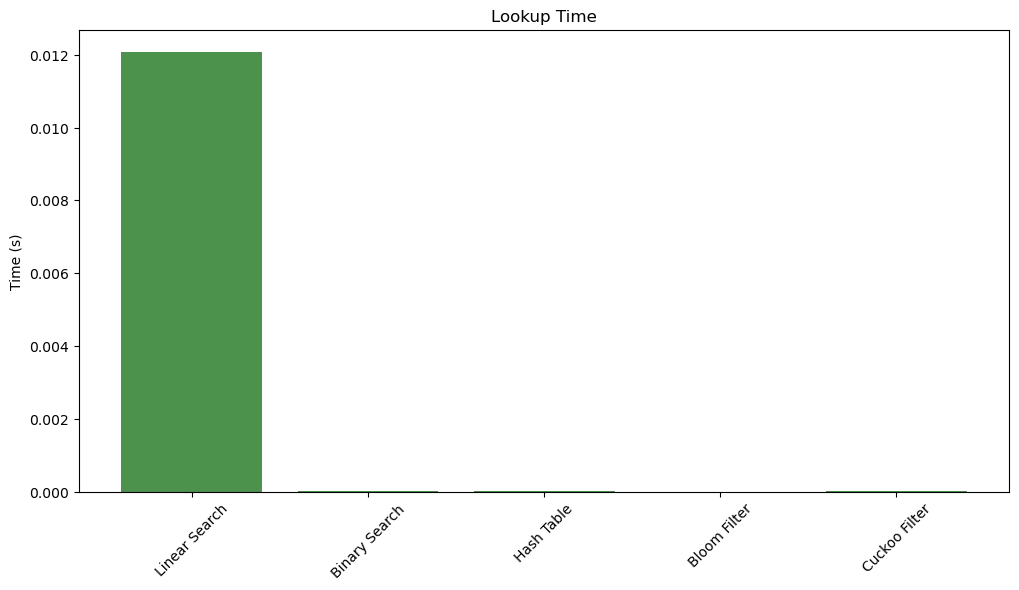

In [61]:
# Extract labels and times
labels = list(results.keys())
lookup_times = [results[name] for name in labels]
x = np.arange(len(labels))

plt.figure(figsize=(12, 6))
plt.bar(x, lookup_times, color='darkgreen', alpha=0.7)
plt.xticks(x, labels, rotation=45)
plt.ylabel("Time (s)")
plt.title("Lookup Time")

plt.show()

## Step 4: Unit test for hashing, bloom and cucko filter

In [41]:
# Unit Testing

class TestFilters(unittest.TestCase):
    def setUp(self):
        self.hash_table = HashTable()
        self.bloom_filter = BloomFilter(1000, 3)
        self.cuckoo_filter = CuckooFilter(capacity=100000, bucket_size=4, fingerprint_size=16)
        self.sample_key = "test_user"
    
    def test_insert_and_lookup(self):
        #hash table
        self.hash_table.insert(self.sample_key)
        self.assertTrue(self.hash_table.lookup(self.sample_key))
        # Bloom filter
        self.bloom_filter.insert(self.sample_key)
        self.assertTrue(self.bloom_filter.lookup(self.sample_key))
        #Cuckoo
        self.cuckoo_filter.insert(self.sample_key)
        self.assertTrue(self.cuckoo_filter.lookup(self.sample_key))
    
    def test_delete(self):
        self.hash_table.insert(self.sample_key)
        self.hash_table.delete(self.sample_key)
        self.assertFalse(self.hash_table.lookup(self.sample_key))
        
        self.cuckoo_filter.insert(self.sample_key)
        self.cuckoo_filter.delete(self.sample_key)
        self.assertFalse(self.cuckoo_filter.lookup(self.sample_key))

if __name__ == "__main__":
    unittest.main(argv=['first-arg-is-ignored'], exit=False)


..
----------------------------------------------------------------------
Ran 2 tests in 0.290s

OK
